importing libraries


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score


dataset info

In [4]:
df = pd.read_csv("Telco-Customer-Churn.csv")

print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
# Drop customerID (not useful)
df.drop("customerID", axis=1, inplace=True)

# Fix TotalCharges column (has spaces)
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

# Fill missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Convert target column
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print(df.isnull().sum())


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


/tmp/ipython-input-2219389071.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


eda

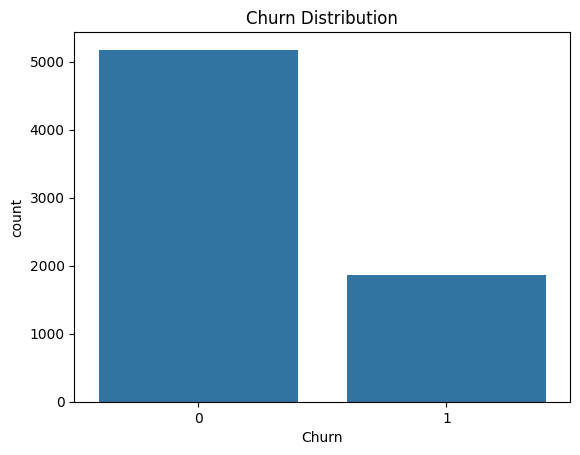

In [15]:
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()


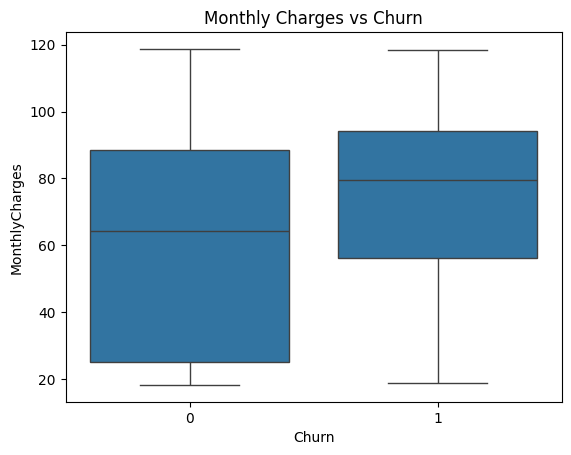

In [16]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


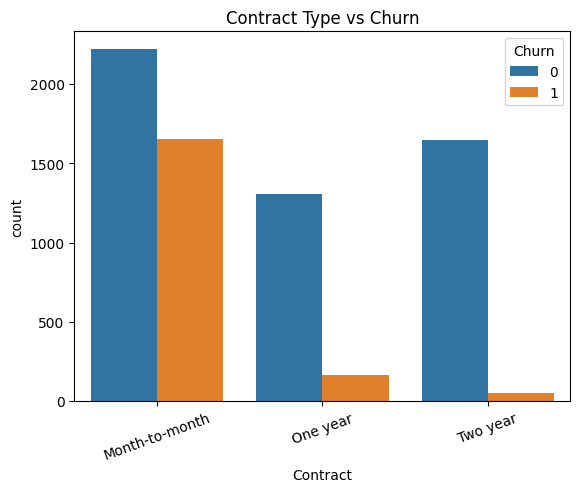

In [17]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=20)
plt.show()


encoding and cleaning


In [18]:
df_encoded = pd.get_dummies(df, drop_first=True)

print(df_encoded.shape)
df_encoded.head()


(7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


training

In [19]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (5634, 30)
Validation size: (1409, 30)


In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


log reg

In [22]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_val_scaled)
y_prob_lr = log_reg.predict_proba(X_val_scaled)[:, 1]


In [23]:
print("=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_val, y_prob_lr))

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred_lr))


=== Logistic Regression Results ===
Accuracy: 0.8069552874378992
ROC AUC: 0.8415846443979436

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



error analysis (confusion matrix)

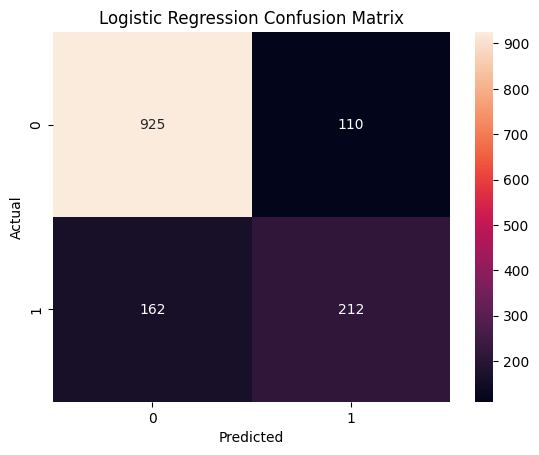

In [24]:
cm_lr = confusion_matrix(y_val, y_pred_lr)

sns.heatmap(cm_lr, annot=True, fmt="d")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


random forest

In [25]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)[:, 1]


In [26]:
print("=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_prob_rf))

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred_rf))


=== Random Forest Results ===
Accuracy: 0.7892122072391767
ROC AUC: 0.8245705133173165

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



error analysis (confusion matrix)

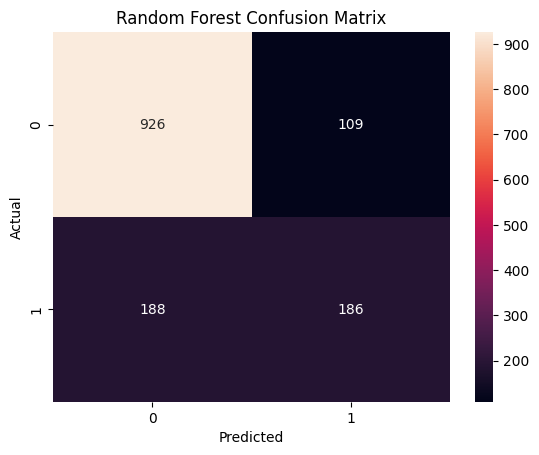

In [27]:
cm_rf = confusion_matrix(y_val, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


evaluation

In [28]:
print("===== Model Comparison =====")

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))

print("\nLogistic Regression ROC AUC:", roc_auc_score(y_val, y_prob_lr))
print("Random Forest ROC AUC:", roc_auc_score(y_val, y_prob_rf))


===== Model Comparison =====
Logistic Regression Accuracy: 0.8069552874378992
Random Forest Accuracy: 0.7892122072391767

Logistic Regression ROC AUC: 0.8415846443979436
Random Forest ROC AUC: 0.8245705133173165


In [29]:
if roc_auc_score(y_val, y_prob_rf) > roc_auc_score(y_val, y_prob_lr):
    print(" Best Model: Random Forest")
else:
    print(" Best Model: Logistic Regression")


 Best Model: Logistic Regression
